In [1]:
# Cell 1: Imports
# https://medium.com/@figueiredor.pedro/how-to-customize-hyperparameter-optimization-5ab1a55db1a
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import xgboost as xgb
from sklearn.metrics import f1_score
import numpy as np
from sklearn.metrics import fbeta_score
from sklearn.metrics import make_scorer,average_precision_score
from sklearn.model_selection import cross_val_score,GridSearchCV


from plots.feature_plots import plot_roc_auc, plot_confusion_matrix
from data.processed_data import save_feature_data,load_feature_data

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [2]:
feature_df = load_feature_data()

# Separate features and target
X = feature_df.drop(columns=["SepsisLabel"], errors="ignore")
y = feature_df["SepsisLabel"]

Feature data loaded from feature_data.pkl


In [3]:
# Cell 4: Train/test split
neg_samples, pos_samples = y.value_counts()
print(f"Negative samples: {neg_samples}, Positive samples: {pos_samples}")

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

Negative samples: 1511067, Positive samples: 27594


In [4]:
# Cell 5: Train model
model = xgb.XGBClassifier(
    random_state=42,
    objective='binary:logistic',
    eval_metric='auc',
    scale_pos_weight=neg_samples / pos_samples
)
model.fit(X_train, y_train, 
          eval_set=[(X_test, y_test)],
          verbose=1)

[0]	validation_0-auc:0.79445
[1]	validation_0-auc:0.81689
[2]	validation_0-auc:0.82549
[3]	validation_0-auc:0.83250
[4]	validation_0-auc:0.83816
[5]	validation_0-auc:0.84279
[6]	validation_0-auc:0.84706
[7]	validation_0-auc:0.85089
[8]	validation_0-auc:0.85306
[9]	validation_0-auc:0.85675
[10]	validation_0-auc:0.85986
[11]	validation_0-auc:0.86310
[12]	validation_0-auc:0.86464
[13]	validation_0-auc:0.86682
[14]	validation_0-auc:0.86837
[15]	validation_0-auc:0.87066
[16]	validation_0-auc:0.87279
[17]	validation_0-auc:0.87480
[18]	validation_0-auc:0.87643
[19]	validation_0-auc:0.87734
[20]	validation_0-auc:0.87850
[21]	validation_0-auc:0.88013
[22]	validation_0-auc:0.88205
[23]	validation_0-auc:0.88350
[24]	validation_0-auc:0.88396
[25]	validation_0-auc:0.88471
[26]	validation_0-auc:0.88590
[27]	validation_0-auc:0.88698
[28]	validation_0-auc:0.88815
[29]	validation_0-auc:0.89001
[30]	validation_0-auc:0.89071
[31]	validation_0-auc:0.89099
[32]	validation_0-auc:0.89180
[33]	validation_0-au

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, ...)

Subset ROC AUC (predicted=1 or actual=1): 0.654


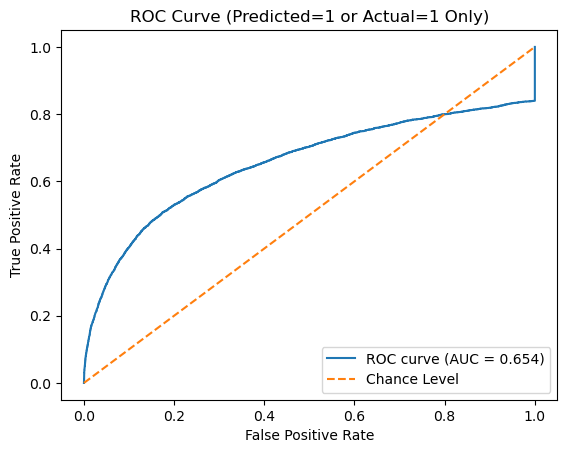

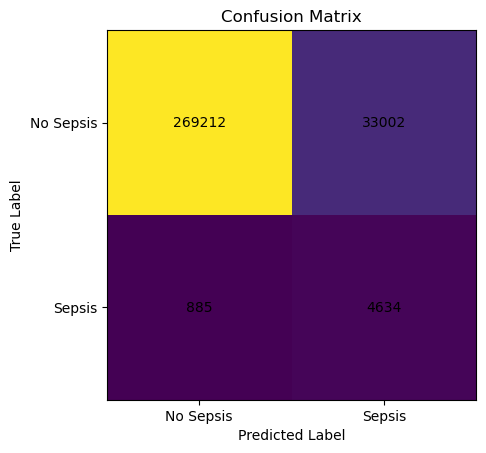


Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.89      0.94    302214
           1       0.12      0.84      0.21      5519

    accuracy                           0.89    307733
   macro avg       0.56      0.87      0.58    307733
weighted avg       0.98      0.89      0.93    307733



In [5]:
# Cell 6: Evaluate model
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

# Plot ROC curve
plot_roc_auc(model, X_test, y_test)

# Plot confusion matrix
plot_confusion_matrix(y_test, y_pred, labels=("No Sepsis", "Sepsis"))

# Print classification metrics
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

In [6]:
thresholds = np.arange(0.0, 1.0, 0.01)
f1_scores = []
for t in thresholds:
    y_pred_threshold = (y_proba >= t).astype(int)
    f1 = f1_score(y_test, y_pred_threshold)
    f1_scores.append(f1)

optimal_threshold = thresholds[np.argmax(f1_scores)]
print(f"Optimal threshold: {optimal_threshold}, F1 Score: {max(f1_scores)}")

Optimal threshold: 0.84, F1 Score: 0.4081908952445422


In [7]:
thresholds = np.arange(0.0, 1.0, 0.01)
f2_scores = []
for t in thresholds:
    y_pred_threshold = (y_proba >= t).astype(int)
    f2 = fbeta_score(y_test, y_pred_threshold, beta=7)
    f2_scores.append(f2)

optimal_threshold = thresholds[np.argmax(f2_scores)]
print(f"Optimal threshold: {optimal_threshold}, F2 Score: {max(f2_scores)}")

Optimal threshold: 0.44, F2 Score: 0.7582072275816948


In [8]:
# Get predicted probabilities for the positive class
y_proba = model.predict_proba(X_test)[:, 1]

# Apply the threshold to get the new predictions
y_pred_custom = (y_proba >= optimal_threshold).astype(int)

# Now evaluate using the new predictions
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_test, y_pred_custom))
print(confusion_matrix(y_test, y_pred_custom))

              precision    recall  f1-score   support

           0       1.00      0.86      0.92    302214
           1       0.10      0.87      0.18      5519

    accuracy                           0.86    307733
   macro avg       0.55      0.87      0.55    307733
weighted avg       0.98      0.86      0.91    307733

[[259545  42669]
 [   698   4821]]


Subset ROC AUC (predicted=1 or actual=1): 0.700


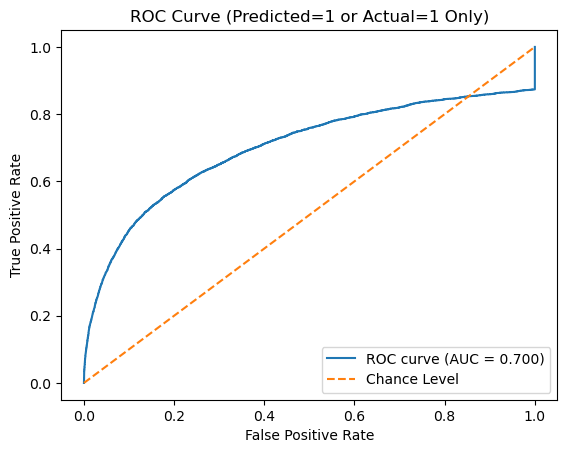

In [9]:
plot_roc_auc(model, X_test, y_test, optimal_threshold)